In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt

## 데이터 준비하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
drive_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/ResNet 구현"
local_data_path = "/content/data"

if os.path.exists(f"{drive_path}/train.tar")and os.path.exists(f"{drive_path}/test.tar"):
    print("tar 파일 발견. tarv 파일 로딩 시작.")

    !mkdir -p {local_data_path}

    !cp "{drive_path}/train.tar" /content/
    !cp "{drive_path}/test.tar" /content/

    print("압축 해제 중...")
    !tar -xf /content/train.tar -C {local_data_path}
    !tar -xf /content/test.tar -C {local_data_path}
else:
    print("최초 실행 : 원본 데이터(7z) 변환 작업 시작")
    !cp "{drive_path}/train.7z" /content/
    !cp "{drive_path}/test.7z" /content/

    !mkdir -p {local_data_path}
    !7z x /content/train.7z -o{local_data_path} -y > /dev/null 2>&1
    !7z x /content/test.7z -o{local_data_path} -y > /dev/null 2>&1
    print("데이터 변환 및 백업 중 ..")
    !tar -cf /content/train.tar -C {local_data_path} train
    !tar -cf /content/test.tar -C {local_data_path} test

    !mv /content/train.tar "{drive_path}/"
    !mv /content/test.tar "{drive_path}/"

최적화된 데이터(tar)가 있습니다. 로딩 시작합니다.
압축 해제 중...


In [ ]:
!ls /content/data

test  train


In [ ]:
!ls /content/data/train | tail # head
!ls /content/data/test | tail # head

9993.png
9994.png
9995.png
9996.png
9997.png
9998.png
9999.png
999.png
99.png
9.png
99994.png
99995.png
99996.png
99997.png
99998.png
99999.png
9999.png
999.png
99.png
9.png


In [ ]:
import os

input_dir = '/content/data/test'
output_dir = '/content/data/train'

# 1. 경로가 진짜 있는지 먼저 체크
if not os.path.exists(input_dir):
    print(f"경로를 찾을 수 없습니다.: {input_dir}")

else:
    # 2. 파일 개수 확인
    input_files = [f for f in os.listdir(input_dir) if not f.startswith('.')]
    output_files = [f for f in os.listdir(output_dir) if not f.startswith('.')]

    print(f"Test 파일: {len(input_files)}개")
    print(f"Train 파일: {len(output_files)}개")

### Transform 정의하기 + Augmentation
데이터 전처리 순서
- Augmentation
- ToTensor()
- Normalization

In [ ]:
train_transform = transforms.Compose([
    # Augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2,
                           contrast = 0.2,
                           saturation = 0.2,
                           hue = 0.1),

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.405], std=[0.229, 0.224, 0.225])])

### Custom Dataset 정의하기

In [ ]:
class_to_idx = {
    'airplane' : 0,
    'automobile' : 1,
    'bird' : 2,
    'cat' : 3,
    'deer' : 4,
    'dog' : 5,
    'frog' : 6,
    'horse' : 7,
    'ship' : 8,
    'truck' : 9
}

idx_to_class = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

In [ ]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class Mydataset(Dataset):
    # img_id = 1 -> 1.png 열기
    # img_id = 2 -> 2.png 열기
    # 이미지 폴더 위치 저장 / CSV 파일 읽어서 저장 / Transform 기억
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self): # 전체 데이터 개수 알려준다. DataLoader가 반복 횟수 계산할 떄 필요함
        return len(self.labels_df)

    def __getitem__(self, idx): # idx 하나로 하나의 샘플을 만드는 함수이다.
        img_id = self.labels_df.iloc[idx, 0]
        label_str = self.labels_df.iloc[idx, 1]
        label = class_to_idx[label_str]

        img_path = os.path.join(self.image_dir, f"{img_id}.png")
        # /content/data/train + 1.png => /content/data/train/1.png
        # os에 따라서 슬래쉬, 역슬래쉬를 쓰는지 달라지기 때문에 os.path.join으로 사용한다.

        image = Image.open(img_path).convert("RGB") # openCV와 다르게 BGR로 안해줘도 괜찮다. [PIL의 특징]
        if self.transform:
            image = self.transform(image )
        return image, label

In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        self.image_ids = sorted([
            int(f.replace('.png', ''))
            for f in os.listdir(image_dir)
            if f.endswith('.png')
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.png")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, img_id


### Dataset 객체 생성

In [ ]:
train_dataset = Mydataset(image_dir = "/content/data/train", csv_file="/content/drive/MyDrive/Colab Notebooks/Computer Vision/ResNet 구현/trainLabels.csv", transform=train_transform)
test_dataset = TestDataset(image_dir = "/content/data/test", transform=test_transform)

## Train -> Train + Validation

In [ ]:
train_size = int(0.8 * len(train_dataset))
print("= = train_size = = ")
print(train_size)

print("= = len(train_dataset) = = ")
print(len(train_dataset))

val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

= = train_size = = 
40000
= = len(train_dataset) = = 
50000


### DataLoader 정의

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

### `dataiter`로 한 배치씩 꺼내서 확인해보기

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images.shape, labels
# 32장 사진 | 3차원 | 224*224

(torch.Size([32, 3, 224, 224]),
 tensor([9, 5, 2, 5, 0, 9, 0, 4, 5, 8, 5, 1, 2, 8, 4, 8, 2, 3, 9, 9, 4, 1, 8, 5,
         1, 3, 9, 3, 7, 7, 6, 7]))

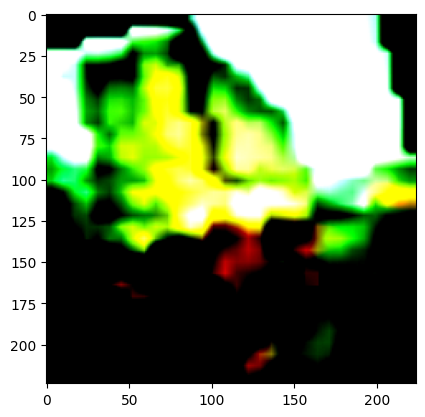

In [ ]:
img_show = images[5]
img_show = img_show.permute(1, 2, 0)

plt.imshow(img_show)
plt.show()

# 👆 왜 까맣게 보이는가?
`transform.Normalize` 때문이다.
- 사람의 눈 (Matplotlib): RGB 이미지를 볼 때 픽셀 값이 0.0(검은색) ~ 1.0(흰색) 사이에 있어야 정상적으로 보여줍니다.<br></br>
- 인공지능 (ResNet): 학습을 잘하려면 데이터의 평균이 0 근처여야 합니다. 그래서 Normalize를 하면 값이 -2.0 ~ +2.0 같은 범위(음수 포함)로 바뀝니다.<br></br>
- 결과: 이미지가 음수 값을 가지게 되니, plt.imshow는 "어? 값이 0보다 작네? 다 검은색으로 칠해야지" 하고 Clipping(잘라냄) 처리를 해버린 것입니다. (경고 메시지 Clipping input data...가 바로 그 뜻입니다.)

# 신경망

ResNet에서는 34-layer까지는 **Basic Block을 사용**하였고, 더 깊은 구조에서는 **Bottleneck구조를 사용**하였습니다. <br><br>
Basic Block 은 3x3 convolution + 3x3 convolution의 구조를 가집니다.
ResNet의 깊이가 점점 깊어지면 경우, parameter의 수가 너무 많아지기 때문에 50층 이상인 ResNet에서는 residual block으로 Basic Block대신 Bottleneck Block을 사용하여 층을 쌓게됩니다.



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## BottleNeck Block for ResNet-50

In [ ]:
# class Bottleneck(nn.Module):
#     def __init__(self, inputs):
#         super().__init__()
#         self.layer = nn.Sequential(
#             nn.Conv2d(3, )
#         )

## Basic Block for ResNet-18

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride):
        super().__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, padding_mode='zeros', bias=False)
        # Conv 바로 뒤에 Batch Normalization을 진행하기 때문 : BN은 정규화 이후 Beta Parameter를 더해주는데, 이가 bias 역할을 수행해줌
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, padding_mode='zeros', bias=False)
        # Conv 바로 뒤에 Batch Normalization을 진행하기 때문 : BN은 정규화 이후 Beta Parameter를 더해주는데, 이가 bias 역할을 수행해줌
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != planes:  # 텐서를 더하려면 크기가 같아야 함.
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        # Basic Block에는 반복이 되는 Conv -> BN -> ReLU -> Conv -> BN -> Skip Connection

    # Following [Figure 2. Residual learning: a building block]...
    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()

        # in_channel 3 -> 64 변환 과정 (STEM) [conv1]
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, padding_mode='zeros')
        # 여기서 왜 bias를 왜 제거 해야할까?
        # BN이 Conv의 bias를 무력화하기 때문이다. -> BN의 Beta가 대신 역할 수행



        # 몇줄을 0padding으로 추가할지 output feature map 크기 구하는 공식 사용해서 직접 구하기
        self.bn = nn.BatchNorm2d(64)
        self.ReLU = nn.ReLU(inplace=True)
        self.maxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            BasicBlock(64, 64, 1),
            BasicBlock(64, 64, 1)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, 2),
            BasicBlock(128, 128, 1)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, 2),
            BasicBlock(256, 256, 1)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, 2),
            BasicBlock(512, 512, 1)
        )

        # Head Designing..
        # GAP -> Flatten -> FC
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 어떤 크기든 1x1로 압축
        self.fc = nn.Linear(512, num_classes)

        #self.softmax = nn.Softmax(dim=1)
        # Softmax은 여기서 하지 않는다고 한다 -> CrossEntropyLoss에서 할 예정이기 때문이다.

        # 이해 확립 필요
        #self.avgpool = nn.AveragePool2d((1, 1))
        # FC Layer 전에 feature map을 고정 크기로 만들고 싶을 때 AdaptiveAvgPool 사용 (AdaptiveAvgPool은 )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.ReLU(x)
        x = self.maxPool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1) # [Batch, 512, 1, 1] -> [Batch, 512]로 펴기
        x = self.fc(x)

        return x

### Loss Function & Optimizer 정의하기

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### 모델 훈련 및 정확도 측정

In [ ]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()

    running_loss=0.0

    correct=0
    total=0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad() # 기울기 초기화하기
                              # 이전에 계산된 기울기(Gradient)를 0으로 초기화합니다.
                          # (이걸 안 하면 기울기가 계속 누적되어 엉뚱한 방향으로 학습됩니다.)

        outputs = model(inputs) # 예측하기 (모델이 정답 추측하는 과정)

        loss = criterion(outputs, targets)# 오차 계산: 정답과 얼마나 틀렸는지(Loss) 계산

        loss.backward() #역전파
        # 오차(Loss)를 역으로 전파하여, 각 가중치(Weight)가 오차에 얼마나 기여했는지(Gradient)를 미분으로 계산합니다.
    # 이때, 각 파라미터의 .grad 속성에 기울기 값이 저장됩니다.

        optimizer.step() #가중치 업데이트
        # 위에서 계산된 기울기(Gradient)를 바탕으로, 가중치를 '아주 조금' 수정합니다.
        # W_new = W_old - (learning_rate * gradient) 공식이 여기서 실행됩니다.

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        #accuracy = correct / total
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch} : 평균 Loss = {running_loss / len(train_loader)}")


    return epoch_loss

In [ ]:
def val(model, val_loader, criterion):
    model.eval() # Batch Normalization이 들어갔기 때문에 model.eval()로 진행하기

    test_loss = 0
    correct=0
    total=0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total+= targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    print(f"Validation Accuracy : {accuracy : .2f}%")
    return accuracy


In [ ]:
# final Epoch X, Best output을 내는 모델 사용하기
num_epochs = 20
best_acc = 0.0
best_model_wts = None

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    loss = train(model, train_loader, optimizer, criterion, epoch)
    train_loss.append(loss)

    val_acc = val(model, val_loader, criterion)
    val_accuracy.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model.state_dict()

model.load_state_dict(best_model_wts)

Epoch 0 : 평균 Loss = 1.675570279932022
Validation Accuracy :  50.33%
Epoch 1 : 평균 Loss = 1.1152644295692444
Validation Accuracy :  65.58%
Epoch 2 : 평균 Loss = 0.8992673227071762
Validation Accuracy :  70.60%
Epoch 3 : 평균 Loss = 0.7734791479349137
Validation Accuracy :  72.98%
Epoch 4 : 평균 Loss = 0.6944204401612282
Validation Accuracy :  77.00%
Epoch 5 : 평균 Loss = 0.628605401480198
Validation Accuracy :  76.58%
Epoch 6 : 평균 Loss = 0.5801848064184189
Validation Accuracy :  79.74%
Epoch 7 : 평균 Loss = 0.5405288198947906
Validation Accuracy :  80.10%
Epoch 8 : 평균 Loss = 0.5047662124216556
Validation Accuracy :  80.30%
Epoch 9 : 평균 Loss = 0.46865292773246764
Validation Accuracy :  79.61%
Epoch 10 : 평균 Loss = 0.4365953689098358
Validation Accuracy :  81.80%
Epoch 11 : 평균 Loss = 0.41492899650335313
Validation Accuracy :  82.83%
Epoch 12 : 평균 Loss = 0.38678552317619325
Validation Accuracy :  82.94%
Epoch 13 : 평균 Loss = 0.36007094004154205
Validation Accuracy :  83.42%
Epoch 14 : 평균 Loss = 0.33606

<All keys matched successfully>

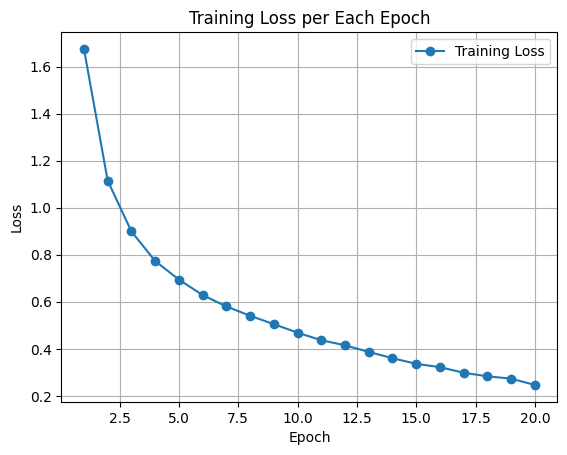

In [ ]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training Loss per Each Epoch")
plt.grid(True)
plt.legend()
plt.show()

# Test Datasets

In [ ]:
def test(model, test_loader):
    model.eval() # Batch Normalization이 들어갔기 때문에 model.eval()로 진행하기

    all_ids=[]
    all_preds=[]

    with torch.no_grad():
        for images, img_ids in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            all_ids.extend(img_ids.numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_ids, all_preds

In [ ]:
all_ids, all_preds = test(model, test_loader)

In [ ]:
pred_labels = [idx_to_class[p] for p in all_preds]
submission = pd.DataFrame({
    "id" : all_ids,
    "label" : pred_labels
})
submission = submission.sort_values('id')
submission.to_csv("submission.csv", index=False)

# 시각화하기

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# 3. 모델을 onnx 파일로 내보냅니다.
torch.onnx.export(model,               # 실행할 모델
                  dummy_input,         # 모델 입력값 (모양 체크용)
                  "resnet18_graph.onnx",   # 저장될 파일 이름
                  verbose=False,
                  input_names=['input'],   # 입력 노드 이름
                  output_names=['output']) # 출력 노드 이름

print("ONNX 파일 저장 완료!")

Applied 39 of general pattern rewrite rules.
ONNX 파일 저장 완료!
